   radius_mean  radius_se  radius_worst  texture_mean  texture_se  \
0     9.791767  15.801552     10.890248      7.542107    8.470448   
1     9.435035  17.791038     13.117328      6.531398    8.612916   
2    13.446636  17.811239     10.091026     16.326392    8.447917   
3     9.003667  16.004747     12.435408     12.702531    8.696990   
4    12.194362  15.537636     14.009485      9.047338    8.375930   

   texture_worst  perimeter_mean  perimeter_se  perimeter_worst  area_mean  \
0      14.240647        8.955319     18.768486        16.280054   6.432209   
1      18.772725       12.359374     17.280451        14.220652  11.263563   
2      15.396010       11.650789     17.357305        22.170936  10.812727   
3      15.834603        5.958071     21.281087        13.063830   6.095242   
4      15.022767        6.292926     15.708427        17.123716   7.728419   

   ...  concave_points_mean  concave_points_se  concave_points_worst  \
0  ...            16.266032          14.8603

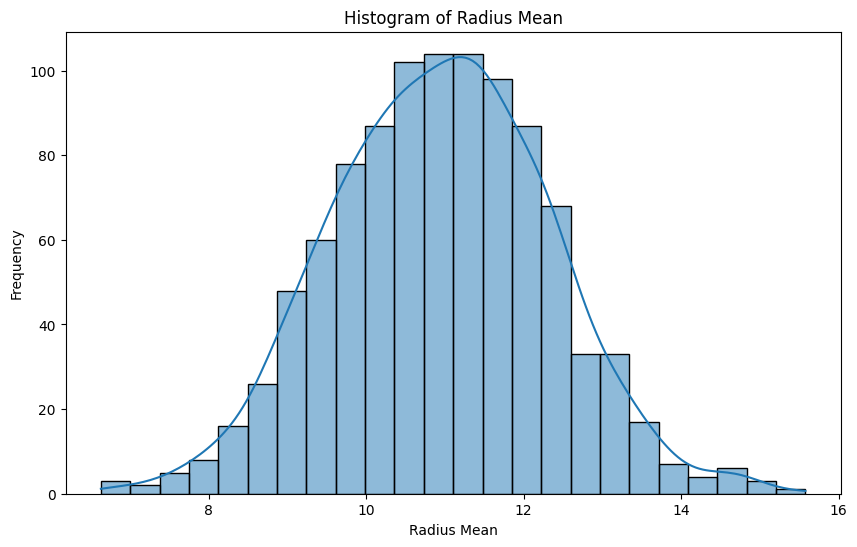

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/breast_cancer.csv'
data = pd.read_csv(file_path)

print(data.head())

# Visualize data - Histogram of 'radius_mean'
plt.figure(figsize=(10, 6))
sns.histplot(data['radius_mean'], kde=True)
plt.title('Histogram of Radius Mean')
plt.xlabel('Radius Mean')
plt.ylabel('Frequency')
plt.show()


In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('/content/breast_cancer.csv')

# Handle missing values (impute with the mean for this example)
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Convert categorical columns to numerical (if any)
# Assuming 'diagnosis' is a categorical column
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('diagnosis', axis=1))

# Create a DataFrame for the scaled features
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[:-1])

In [5]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=a06d3ee23ebf94b0eabb08c228e372029e78bbaffde4f47470d2ecc062885035
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [8]:


# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler

# Create a Spark session
spark = SparkSession.builder.appName("PCAExample").getOrCreate()

# Load your dataset
# Use the file path relevant to your Colab environment
df = spark.read.csv('/content/breast_cancer.csv', header=True, inferSchema=True)

# Preprocess data: convert all features into a single vector column
feature_cols = df.columns[:-1]  # Assuming the last column is the target
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df)

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df_vector)
df_scaled = scalerModel.transform(df_vector)

# Apply PCA
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")  # k is the number of dimensions after reduction
pcaModel = pca.fit(df_scaled)
result = pcaModel.transform(df_scaled).select("pcaFeatures")

result.show(truncate=False)

+----------------------------------------+
|pcaFeatures                             |
+----------------------------------------+
|[10.960089850084199,-1.8051790139324744]|
|[10.46113499998414,-2.148803958128016]  |
|[9.975084430942442,-1.3598102218649737] |
|[14.126142846425287,-2.483045491276152] |
|[10.890497921361616,-1.5752560637167]   |
|[10.873158222475823,-2.941451473806746] |
|[11.153728551345296,-3.638869344316551] |
|[9.510357275773872,-0.1765068130736038] |
|[11.57987857212295,-3.3621918426434316] |
|[9.113834479075138,-0.4405983822461954] |
|[11.68385866579453,-3.018313307389023]  |
|[9.873766825414748,-3.0995686983507387] |
|[12.230933334640678,-3.8372631674520132]|
|[9.748804821394248,-3.8010414008974798] |
|[12.195917388884341,-4.7850206357369265]|
|[10.269633123928573,-3.7771785935311857]|
|[11.466870141009029,-3.1517170212947416]|
|[8.604436135068866,-0.8591255204784928] |
|[10.1902064891194,-2.408313447755662]   |
|[10.470061128815264,-2.1805835926010158]|
+----------

In [11]:

from pyspark.ml.clustering import KMeans

# Create a Spark session
spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

# Load your dataset
df = spark.read.csv('/content/breast_cancer.csv', header=True, inferSchema=True)

# Preprocess data: Convert all features into a single vector column
feature_cols = df.columns[:-1]  # Assuming the last column is the target or label
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df)

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
df_scaled = scaler.fit(df_vector).transform(df_vector)

# Apply K-means clustering
kmeans = KMeans(featuresCol="scaledFeatures", k=3)  # Set the number of clusters (k) as needed
model = kmeans.fit(df_scaled)

# Make predictions
predictions = model.transform(df_scaled)

# Evaluate clustering by computing Silhouette score
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Show results
predictions.select("prediction").show()

Silhouette with squared euclidean distance = 0.03170652864480701
+----------+
|prediction|
+----------+
|         2|
|         0|
|         0|
|         2|
|         0|
|         1|
|         1|
|         0|
|         2|
|         0|
|         2|
|         1|
|         2|
|         1|
|         1|
|         1|
|         2|
|         0|
|         0|
|         2|
+----------+
only showing top 20 rows



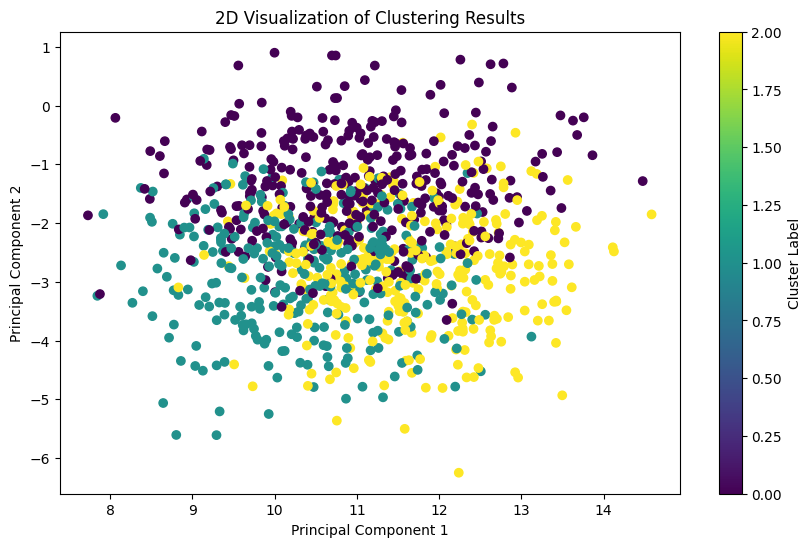

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import PCA as PCAml

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = predictions.toPandas()

# If you have many features, reduce dimensions for visualization (using PCA for example)
pca = PCAml(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(df_scaled)
result = pca_model.transform(df_scaled).select("pcaFeatures")
result = result.toPandas()

# Extract the PCA features for plotting
result['pca_x'] = result['pcaFeatures'].apply(lambda x: x[0])
result['pca_y'] = result['pcaFeatures'].apply(lambda x: x[1])

# Merge with original Pandas DataFrame to get cluster information
pandas_df = pandas_df.join(result)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['pca_x'], pandas_df['pca_y'], c=pandas_df['prediction'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Clustering Results')
plt.colorbar(label='Cluster Label')
plt.show()